# The Rumelhart network in tensorflow 2.0 / keras

This notebook uses tensorflow 2.0 with Keras to implement the Rumelhart model of semantic cognition as described by Rogers and McClelland in the book *Semantic Cogntion: A Parallel Distributed Processing Approach*. Here is an image of the architecture from the book:

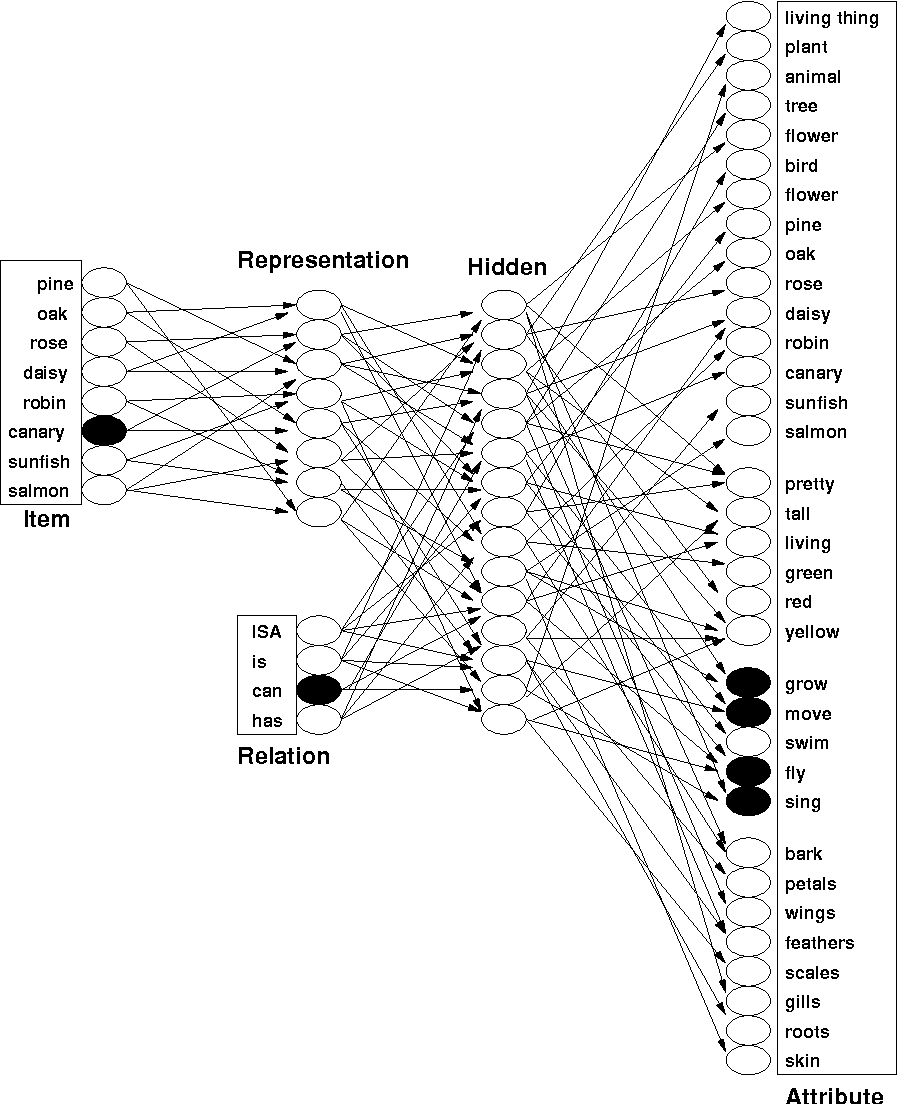

The model answers simple questions about the properties of animals and plants. There are 8 items in its world (indicated by labels on the *Item* input layer) and four questions that can be asked (indicated by the labels on the *Relation* input layer. Given an item and relation query as input, the model must activate all of the properties that are both true of the item and of the correct relationship type. **NOTE** that the illustration does not show all attribute units.

## Imports to build and fit model

In [11]:
#For basic data types and functions
import numpy as np

#Tensorflow 
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate

#For visualization / analysis
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.manifold import MDS

## Model environment

There are 8 total items and 4 possible query relations making a total of 32 possible input/output patterns. Since the Item and Relation inputs get applied to two different layers, we will construct a numpy array for each, possessing 32 rows (32 input patterns) and columns equal to the number of units in each layer.

In [3]:
#One-hot vectors for 8 input items, repeated 4 times (one for each context)
item_input_pats = np.array([
         [1,0,0,0,0,0,0,0],
         [0,1,0,0,0,0,0,0],
         [0,0,1,0,0,0,0,0],
         [0,0,0,1,0,0,0,0],
         [0,0,0,0,1,0,0,0],
         [0,0,0,0,0,1,0,0],
         [0,0,0,0,0,0,1,0],
         [0,0,0,0,0,0,0,1],
    
         [1,0,0,0,0,0,0,0],
         [0,1,0,0,0,0,0,0],
         [0,0,1,0,0,0,0,0],
         [0,0,0,1,0,0,0,0],
         [0,0,0,0,1,0,0,0],
         [0,0,0,0,0,1,0,0],
         [0,0,0,0,0,0,1,0],
         [0,0,0,0,0,0,0,1],
    
         [1,0,0,0,0,0,0,0],
         [0,1,0,0,0,0,0,0],
         [0,0,1,0,0,0,0,0],
         [0,0,0,1,0,0,0,0],
         [0,0,0,0,1,0,0,0],
         [0,0,0,0,0,1,0,0],
         [0,0,0,0,0,0,1,0],
         [0,0,0,0,0,0,0,1],
    
         [1,0,0,0,0,0,0,0],
         [0,1,0,0,0,0,0,0],
         [0,0,1,0,0,0,0,0],
         [0,0,0,1,0,0,0,0],
         [0,0,0,0,1,0,0,0],
         [0,0,0,0,0,1,0,0],
         [0,0,0,0,0,0,1,0],
         [0,0,0,0,0,0,0,1]], 
    dtype='f')

#Four different query contexts, each repeated once for each item
query_input_pats = np.array([
    [1,0,0,0],
    [1,0,0,0],
    [1,0,0,0],
    [1,0,0,0],
    [1,0,0,0],
    [1,0,0,0],
    [1,0,0,0],
    [1,0,0,0],

    [0,1,0,0],
    [0,1,0,0],
    [0,1,0,0],
    [0,1,0,0],
    [0,1,0,0],
    [0,1,0,0],
    [0,1,0,0],
    [0,1,0,0],

    [0,0,1,0],
    [0,0,1,0],
    [0,0,1,0],
    [0,0,1,0],
    [0,0,1,0],
    [0,0,1,0],
    [0,0,1,0],
    [0,0,1,0],

    [0,0,0,1],
    [0,0,0,1],
    [0,0,0,1],
    [0,0,0,1],
    [0,0,0,1],
    [0,0,0,1],
    [0,0,0,1],
    [0,0,0,1]], 
    dtype='f')

#Output attributes for each item-context combination
att_output_pats = np.array([
    [1,1,0,1,0,0,0,1,0,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [1,1,0,1,0,0,0,0,1,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [1,1,0,0,1,0,0,0,0,1,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [1,1,0,0,1,0,0,0,0,0,1,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [1,0,1,0,0,1,0,0,0,0,0,1,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [1,0,1,0,0,1,0,0,0,0,0,0,1,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [1,0,1,0,0,0,1,0,0,0,0,0,0,1,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [1,0,1,0,0,0,1,0,0,0,0,0,0,0,1, 0,0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,1,1,1,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,1,1,0,0,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 1,0,1,0,1,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 1,0,1,0,0,1, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,1,0,1,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,1,0,0,1, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,1,0,0,1, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,1,0,1,0, 0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 1,1,0,1,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 1,1,0,1,1, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 1,1,1,0,0, 0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 1,1,1,0,0, 0,0,0,0,0,0,0,0,0,0],

    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,1,0,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,1,1,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,1,1,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 0,1,1,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 1,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 1,0,0,0,0,0,1,1,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 1,0,0,0,0,0,0,0,1,1],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0, 0,0,0,0,0, 1,0,0,0,0,0,0,0,1,1]], 
    dtype='f')


Here are some arrays of labels for later use in plotting/analysis

In [4]:
#Labels for inputs, contexts

#item names:
inames = ['pine','oak','rose','daisy','robin','canary', 'sunfish', 'salmon']

#query names:
qnames = ['isa','is','can','has']

#Item-in-context names:
patnames = ['pine_isa','oak_isa','rose_isa','daisy_isa','robin_isa','canary_isa', 'sunfish_isa','salmon_isa',
           'pine_is','oak_is','rose_is','daisy_is','robin_is','canary_is', 'sunfish_is','salmon_is',
           'pine_can','oak_can','rose_can','daisy_can','robin_can','canary_can', 'sunfish_can','salmon_can',
           'pine_has','oak_has','rose_has','daisy_has','robin_has','canary_has','sunfish_has','salmon_has']

#Attribute names
attnames = ['LivingThing','Plant','Animal','Tree','Flower','Bird','Fish',
            'Pine','Oak','Rose','Daisy','Robin','Canary','Sunfish', 'Salmon',
            'pretty','tall','living','green','red','yellow',
            'grow','move','swim','fly','sing',
            'skin','roots','leaves','bark','branch','petals','wings','feathers','scales','gills'            
           ]

## Parameters for model

Often in cognitive models we want some control over model parameters that get hidden in defaults for standard machine-learning tutorials. The parameters can be set by creating an object of the appropriate type, and specifying the parameters when it is created. I will set these parameters in the following block; they can be altered to investigate the consequences of other choices.

In [5]:
#Parameterize distribution of initial weights.

#These parameters are from the book. Run with batch-size 1 (online learning)
#and binary crossentropy error for 3500 epochs (as stated in book) gets it
#most of the way there, but still struggling to activate specific names.
#It also takes about 20 minutes to train with these parameters:

#Weight initialization
#Reported in book:
#wt_init = tf.keras.initializers.RandomUniform(minval = -0.9, maxval = 0.9, seed = None)

wt_init = tf.keras.initializers.RandomUniform(minval = -0.1, maxval = 0.1, seed = None)

#Select and parameterize the optimization algorithm:
opt = tf.keras.optimizers.SGD(lr=0.1, nesterov = False, momentum = 0.0, decay = 0.0)

#Everything goes much faster with the adam optimizer, batch-size 32 and 7k epochs as set below

The initializer will set the starting weights to a sample from the specified uniform random distribution. It must be specified for both the receiving weights and the bias weights when the relevant layer is created. The optimizer chosen above replicates the original work---unvarnished gradient descent without momentum or decay.

## Read an already-trained model

In [7]:
rumnet = load_model('rumnet_trained_2500eps.h5')

## Build model

We will use the Keras API to build the model. Note the model has two input layers, with the first *Item* input connecting to the first hidden layer, and with the second input layer and the first hidden layer both connecting to the second hidden layer. The architecture is not just a single stack of layers, so we can't use the Sequential model type from Keras.

In [6]:
item_in = Input(shape=(8,)) #One-hot input representation of the item
cont_in = Input(shape=(4,)) #One-hot input representation for the query context

#Learned item representation (first hidden layer)
itemrep = Dense(8,activation='sigmoid',kernel_initializer=wt_init, bias_initializer=wt_init)(item_in) 

#Concatenate item representation and context input units
ir_and_cont = concatenate([itemrep, cont_in])    

#Connect concatenated layers to second hidden layer
contrep = Dense(16,activation='sigmoid', kernel_initializer=wt_init, bias_initializer=wt_init)(ir_and_cont)

#Connect to output attributes
attributes = Dense(36, activation='sigmoid', kernel_initializer=wt_init, bias_initializer=wt_init)(contrep)

#Construct model object called rumnet
rumnet=Model(inputs=[item_in, cont_in], outputs=attributes)

print(rumnet.summary()) #Check to make sure it looks right

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            72          input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 12)           0           dense[0][0]                      
                                                                 input_2[0][0]                

## Compile model

Book does not state loss function. My experiments here find approximately similar results using binary cross-entropy error so I will use that here. With the original parameters noted above and online learning using SGD without momentum or decay (as set above and using a batch size of 1 during training), the model learns but takes a relatively long time to train. Using the ADAM optimizer with default parameters and batch learning it goes much faster.

In [7]:
#Now compile it, specifying important parameters such as the loss and optimization algorithm
rumnet.compile(optimizer='adam', loss='binary_crossentropy')

## Fit model

In [49]:
iwts = rumnet.get_weights() #Store initial weights for later replication
H = rumnet.fit(x=[item_input_pats, query_input_pats], y=att_output_pats, batch_size=32, epochs = 7000)

Train on 32 samples
Epoch 1/7000
32/32 [==============================] - 0s 13ms/sample - loss: 0.6934
Epoch 2/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.6896
Epoch 3/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.6859
Epoch 4/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.6821
Epoch 5/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.6784
Epoch 6/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.6747
Epoch 7/7000
32/32 [==============================] - 0s 156us/sample - loss: 0.6709
Epoch 8/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.6672
Epoch 9/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.6635
Epoch 10/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.6598
Epoch 11/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.6561
Epoch 12/7000
32/32 [=============================

Epoch 97/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.3844
Epoch 98/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.3822
Epoch 99/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.3802
Epoch 100/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.3781
Epoch 101/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.3761
Epoch 102/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.3741
Epoch 103/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.3721
Epoch 104/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.3701
Epoch 105/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.3682
Epoch 106/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.3663
Epoch 107/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.3645
Epoch 108/7000
32/32 [==============================]

Epoch 193/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2828
Epoch 194/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2824
Epoch 195/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2821
Epoch 196/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2817
Epoch 197/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2814
Epoch 198/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2810
Epoch 199/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2807
Epoch 200/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2803
Epoch 201/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2800
Epoch 202/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2797
Epoch 203/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2794
Epoch 204/7000
32/32 [==============================] 

Epoch 289/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2657
Epoch 290/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2656
Epoch 291/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2655
Epoch 292/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2655
Epoch 293/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2654
Epoch 294/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2653
Epoch 295/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2653
Epoch 296/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2652
Epoch 297/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2652
Epoch 298/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2651
Epoch 299/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2650
Epoch 300/7000
32/32 [==============================] 

Epoch 385/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2621
Epoch 386/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2621
Epoch 387/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2621
Epoch 388/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2621
Epoch 389/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2620
Epoch 390/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2620
Epoch 391/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2620
Epoch 392/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2620
Epoch 393/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2620
Epoch 394/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2620
Epoch 395/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2619
Epoch 396/7000
32/32 [==============================]

Epoch 481/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2611
Epoch 482/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2611
Epoch 483/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2611
Epoch 484/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2610
Epoch 485/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2610
Epoch 486/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2610
Epoch 487/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2610
Epoch 488/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2610
Epoch 489/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2610
Epoch 490/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2610
Epoch 491/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2610
Epoch 492/7000
32/32 [==============================]

Epoch 577/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2606
Epoch 578/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2606
Epoch 579/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2606
Epoch 580/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2606
Epoch 581/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2606
Epoch 582/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2606
Epoch 583/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2606
Epoch 584/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2606
Epoch 585/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2606
Epoch 586/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2606
Epoch 587/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2606
Epoch 588/7000
32/32 [==============================]

Epoch 673/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2603
Epoch 674/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2603
Epoch 675/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2603
Epoch 676/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2603
Epoch 677/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2603
Epoch 678/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2603
Epoch 679/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2603
Epoch 680/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2603
Epoch 681/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2603
Epoch 682/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2603
Epoch 683/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2603
Epoch 684/7000
32/32 [==============================]

Epoch 769/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2600
Epoch 770/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2600
Epoch 771/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2600
Epoch 772/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2600
Epoch 773/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2600
Epoch 774/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2600
Epoch 775/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2600
Epoch 776/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2600
Epoch 777/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2600
Epoch 778/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2600
Epoch 779/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2599
Epoch 780/7000
32/32 [=============================

Epoch 865/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2596
Epoch 866/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2596
Epoch 867/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2596
Epoch 868/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2596
Epoch 869/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2596
Epoch 870/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2596
Epoch 871/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2596
Epoch 872/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2596
Epoch 873/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2596
Epoch 874/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2596
Epoch 875/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2596
Epoch 876/7000
32/32 [==============================] 

Epoch 961/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2592
Epoch 962/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2592
Epoch 963/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2592
Epoch 964/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2592
Epoch 965/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2592
Epoch 966/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2592
Epoch 967/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2592
Epoch 968/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2592
Epoch 969/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2592
Epoch 970/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2592
Epoch 971/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2592
Epoch 972/7000
32/32 [==============================]

Epoch 1056/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2587
Epoch 1057/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2587
Epoch 1058/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2587
Epoch 1059/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2587
Epoch 1060/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2587
Epoch 1061/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2587
Epoch 1062/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2587
Epoch 1063/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2587
Epoch 1064/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2587
Epoch 1065/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2587
Epoch 1066/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2587
Epoch 1067/7000
32/32 [====================

Epoch 1151/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2581
Epoch 1152/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2581
Epoch 1153/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2581
Epoch 1154/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2581
Epoch 1155/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2581
Epoch 1156/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2581
Epoch 1157/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2581
Epoch 1158/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2581
Epoch 1159/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2581
Epoch 1160/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2580
Epoch 1161/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2580
Epoch 1162/7000
32/32 [====================

Epoch 1246/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2573
Epoch 1247/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2573
Epoch 1248/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2573
Epoch 1249/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2572
Epoch 1250/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2572
Epoch 1251/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2572
Epoch 1252/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2572
Epoch 1253/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2572
Epoch 1254/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2572
Epoch 1255/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2572
Epoch 1256/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2572
Epoch 1257/7000
32/32 [====================

Epoch 1341/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2560
Epoch 1342/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2560
Epoch 1343/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2560
Epoch 1344/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2559
Epoch 1345/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2559
Epoch 1346/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2559
Epoch 1347/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2559
Epoch 1348/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2559
Epoch 1349/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2558
Epoch 1350/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2558
Epoch 1351/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2558
Epoch 1352/7000
32/32 [====================

Epoch 1436/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2537
Epoch 1437/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2536
Epoch 1438/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2536
Epoch 1439/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2536
Epoch 1440/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2535
Epoch 1441/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2535
Epoch 1442/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2535
Epoch 1443/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2534
Epoch 1444/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2534
Epoch 1445/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2534
Epoch 1446/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2533
Epoch 1447/7000
32/32 [====================

Epoch 1531/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2493
Epoch 1532/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2492
Epoch 1533/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2492
Epoch 1534/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2491
Epoch 1535/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2490
Epoch 1536/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2490
Epoch 1537/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2489
Epoch 1538/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2489
Epoch 1539/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2488
Epoch 1540/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2487
Epoch 1541/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2487
Epoch 1542/7000
32/32 [====================

Epoch 1626/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2424
Epoch 1627/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2423
Epoch 1628/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2422
Epoch 1629/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2421
Epoch 1630/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2420
Epoch 1631/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2420
Epoch 1632/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2419
Epoch 1633/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2418
Epoch 1634/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2417
Epoch 1635/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2416
Epoch 1636/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2416
Epoch 1637/7000
32/32 [====================

Epoch 1721/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2344
Epoch 1722/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2343
Epoch 1723/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2342
Epoch 1724/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2341
Epoch 1725/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2340
Epoch 1726/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2340
Epoch 1727/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2339
Epoch 1728/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2338
Epoch 1729/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2337
Epoch 1730/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2336
Epoch 1731/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2335
Epoch 1732/7000
32/32 [====================

Epoch 1816/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2267
Epoch 1817/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2266
Epoch 1818/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2265
Epoch 1819/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2265
Epoch 1820/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2264
Epoch 1821/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2263
Epoch 1822/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2262
Epoch 1823/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2262
Epoch 1824/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2261
Epoch 1825/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2260
Epoch 1826/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2259
Epoch 1827/7000
32/32 [==================

Epoch 1910/7000
32/32 [==============================] - 0s 156us/sample - loss: 0.2196
Epoch 1911/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2196
Epoch 1912/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2195
Epoch 1913/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2194
Epoch 1914/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2194
Epoch 1915/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2193
Epoch 1916/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2192
Epoch 1917/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2191
Epoch 1918/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2191
Epoch 1919/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2190
Epoch 1920/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2189
Epoch 1921/7000
32/32 [================

Epoch 2004/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2128
Epoch 2005/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2128
Epoch 2006/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2127
Epoch 2007/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2126
Epoch 2008/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2126
Epoch 2009/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2125
Epoch 2010/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2124
Epoch 2011/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2123
Epoch 2012/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2123
Epoch 2013/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.2122
Epoch 2014/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2121
Epoch 2015/7000
32/32 [===================

Epoch 2099/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2058
Epoch 2100/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2058
Epoch 2101/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2057
Epoch 2102/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2056
Epoch 2103/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2055
Epoch 2104/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2055
Epoch 2105/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2054
Epoch 2106/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2053
Epoch 2107/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.2052
Epoch 2108/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.2052
Epoch 2109/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.2051
Epoch 2110/7000
32/32 [====================

Epoch 2193/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1984
Epoch 2194/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1983
Epoch 2195/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1982
Epoch 2196/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1981
Epoch 2197/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1980
Epoch 2198/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1979
Epoch 2199/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1978
Epoch 2200/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1978
Epoch 2201/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1977
Epoch 2202/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1976
Epoch 2203/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1975
Epoch 2204/7000
32/32 [====================

Epoch 2288/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1897
Epoch 2289/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1896
Epoch 2290/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1895
Epoch 2291/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1894
Epoch 2292/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1893
Epoch 2293/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1892
Epoch 2294/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1891
Epoch 2295/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1890
Epoch 2296/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1889
Epoch 2297/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1888
Epoch 2298/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1887
Epoch 2299/7000
32/32 [====================

Epoch 2383/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1799
Epoch 2384/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1798
Epoch 2385/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1797
Epoch 2386/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1796
Epoch 2387/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1794
Epoch 2388/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1793
Epoch 2389/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1792
Epoch 2390/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1791
Epoch 2391/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1790
Epoch 2392/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1789
Epoch 2393/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1788
Epoch 2394/7000
32/32 [====================

32/32 [==============================] - 0s 62us/sample - loss: 0.1700
Epoch 2478/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1699
Epoch 2479/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1698
Epoch 2480/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1697
Epoch 2481/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1696
Epoch 2482/7000
32/32 [==============================] - 0s 95us/sample - loss: 0.1695
Epoch 2483/7000
32/32 [==============================] - 0s 79us/sample - loss: 0.1694
Epoch 2484/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1693
Epoch 2485/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1692
Epoch 2486/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1691
Epoch 2487/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1690
Epoch 2488/7000
32/32 [==============================] - 0

Epoch 2572/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1610
Epoch 2573/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1609
Epoch 2574/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1608
Epoch 2575/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1607
Epoch 2576/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1606
Epoch 2577/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1606
Epoch 2578/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1605
Epoch 2579/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1604
Epoch 2580/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1603
Epoch 2581/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1602
Epoch 2582/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1601
Epoch 2583/7000
32/32 [===================

Epoch 2667/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1535
Epoch 2668/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1534
Epoch 2669/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1533
Epoch 2670/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1532
Epoch 2671/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1532
Epoch 2672/7000
32/32 [==============================] - 0s 95us/sample - loss: 0.1531
Epoch 2673/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1530
Epoch 2674/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1530
Epoch 2675/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1529
Epoch 2676/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1528
Epoch 2677/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1527
Epoch 2678/7000
32/32 [====================

Epoch 2762/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1473
Epoch 2763/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1472
Epoch 2764/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1471
Epoch 2765/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1471
Epoch 2766/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1470
Epoch 2767/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1470
Epoch 2768/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1469
Epoch 2769/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1468
Epoch 2770/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1468
Epoch 2771/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1467
Epoch 2772/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1467
Epoch 2773/7000
32/32 [================

Epoch 2857/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1421
Epoch 2858/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1420
Epoch 2859/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1420
Epoch 2860/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1419
Epoch 2861/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1419
Epoch 2862/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1418
Epoch 2863/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1418
Epoch 2864/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1418
Epoch 2865/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1417
Epoch 2866/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1417
Epoch 2867/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1416
Epoch 2868/7000
32/32 [====================

32/32 [==============================] - 0s 125us/sample - loss: 0.1377
Epoch 2952/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1377
Epoch 2953/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1376
Epoch 2954/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1376
Epoch 2955/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1375
Epoch 2956/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1375
Epoch 2957/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1375
Epoch 2958/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1374
Epoch 2959/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1374
Epoch 2960/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1373
Epoch 2961/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1373
Epoch 2962/7000
32/32 [==============================] - 0

Epoch 3046/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1338
Epoch 3047/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1337
Epoch 3048/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1337
Epoch 3049/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1337
Epoch 3050/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1336
Epoch 3051/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1336
Epoch 3052/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1335
Epoch 3053/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1335
Epoch 3054/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1335
Epoch 3055/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1334
Epoch 3056/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1334
Epoch 3057/7000
32/32 [====================

Epoch 3141/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1301
Epoch 3142/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1301
Epoch 3143/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1300
Epoch 3144/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1300
Epoch 3145/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1300
Epoch 3146/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1299
Epoch 3147/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1299
Epoch 3148/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1299
Epoch 3149/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1298
Epoch 3150/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1298
Epoch 3151/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1297
Epoch 3152/7000
32/32 [====================

32/32 [==============================] - 0s 125us/sample - loss: 0.1265
Epoch 3236/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1265
Epoch 3237/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1265
Epoch 3238/7000
32/32 [==============================] - 0s 156us/sample - loss: 0.1264
Epoch 3239/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1264
Epoch 3240/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1263
Epoch 3241/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1263
Epoch 3242/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1263
Epoch 3243/7000
32/32 [==============================] - 0s 156us/sample - loss: 0.1262
Epoch 3244/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1262
Epoch 3245/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1261
Epoch 3246/7000
32/32 [=============================

Epoch 3330/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1227
Epoch 3331/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1227
Epoch 3332/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1226
Epoch 3333/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1226
Epoch 3334/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1225
Epoch 3335/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1225
Epoch 3336/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1225
Epoch 3337/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1224
Epoch 3338/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1224
Epoch 3339/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1223
Epoch 3340/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1223
Epoch 3341/7000
32/32 [=================

Epoch 3425/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1185
Epoch 3426/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1185
Epoch 3427/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1184
Epoch 3428/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1184
Epoch 3429/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1183
Epoch 3430/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1183
Epoch 3431/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1182
Epoch 3432/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1182
Epoch 3433/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1181
Epoch 3434/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1181
Epoch 3435/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1180
Epoch 3436/7000
32/32 [====================

Epoch 3520/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1139
Epoch 3521/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1139
Epoch 3522/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1138
Epoch 3523/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1138
Epoch 3524/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1137
Epoch 3525/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1137
Epoch 3526/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1136
Epoch 3527/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1136
Epoch 3528/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1135
Epoch 3529/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1135
Epoch 3530/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1134
Epoch 3531/7000
32/32 [====================

Epoch 3614/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1091
Epoch 3615/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1091
Epoch 3616/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1090
Epoch 3617/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1090
Epoch 3618/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1089
Epoch 3619/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1089
Epoch 3620/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1088
Epoch 3621/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1088
Epoch 3622/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1087
Epoch 3623/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1087
Epoch 3624/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1086
Epoch 3625/7000
32/32 [=================

Epoch 3708/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1043
Epoch 3709/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1043
Epoch 3710/7000
32/32 [==============================] - 0s 218us/sample - loss: 0.1042
Epoch 3711/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.1042
Epoch 3712/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1041
Epoch 3713/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1041
Epoch 3714/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.1040
Epoch 3715/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.1040
Epoch 3716/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1039
Epoch 3717/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1039
Epoch 3718/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.1038
Epoch 3719/7000
32/32 [==================

Epoch 3803/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0997
Epoch 3804/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0996
Epoch 3805/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0996
Epoch 3806/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0995
Epoch 3807/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0995
Epoch 3808/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0994
Epoch 3809/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0994
Epoch 3810/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0993
Epoch 3811/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0993
Epoch 3812/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0992
Epoch 3813/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0992
Epoch 3814/7000
32/32 [====================

Epoch 3898/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0954
Epoch 3899/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0954
Epoch 3900/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0953
Epoch 3901/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0953
Epoch 3902/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0952
Epoch 3903/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0952
Epoch 3904/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0952
Epoch 3905/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0951
Epoch 3906/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0951
Epoch 3907/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0950
Epoch 3908/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0950
Epoch 3909/7000
32/32 [===================

32/32 [==============================] - 0s 94us/sample - loss: 0.0917
Epoch 3993/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0916
Epoch 3994/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0916
Epoch 3995/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0916
Epoch 3996/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0915
Epoch 3997/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0915
Epoch 3998/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0914
Epoch 3999/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0914
Epoch 4000/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0914
Epoch 4001/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0913
Epoch 4002/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0913
Epoch 4003/7000
32/32 [==============================] - 0s

Epoch 4087/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0884
Epoch 4088/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0883
Epoch 4089/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0883
Epoch 4090/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0883
Epoch 4091/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0882
Epoch 4092/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0882
Epoch 4093/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0882
Epoch 4094/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0881
Epoch 4095/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0881
Epoch 4096/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0881
Epoch 4097/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0880
Epoch 4098/7000
32/32 [===================

Epoch 4182/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0855
Epoch 4183/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0855
Epoch 4184/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0854
Epoch 4185/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0854
Epoch 4186/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0854
Epoch 4187/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0854
Epoch 4188/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0853
Epoch 4189/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0853
Epoch 4190/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0853
Epoch 4191/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0852
Epoch 4192/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0852
Epoch 4193/7000
32/32 [===================

Epoch 4276/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0830
Epoch 4277/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0830
Epoch 4278/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0830
Epoch 4279/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0830
Epoch 4280/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0829
Epoch 4281/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0829
Epoch 4282/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0829
Epoch 4283/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0829
Epoch 4284/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0829
Epoch 4285/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0828
Epoch 4286/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0828
Epoch 4287/7000
32/32 [====================

Epoch 4371/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0809
Epoch 4372/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0809
Epoch 4373/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0809
Epoch 4374/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0808
Epoch 4375/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0808
Epoch 4376/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0808
Epoch 4377/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0808
Epoch 4378/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0808
Epoch 4379/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0807
Epoch 4380/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0807
Epoch 4381/7000
32/32 [==============================] - 0s 73us/sample - loss: 0.0807
Epoch 4382/7000
32/32 [====================

Epoch 4466/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0790
Epoch 4467/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0790
Epoch 4468/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0790
Epoch 4469/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0790
Epoch 4470/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0790
Epoch 4471/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0790
Epoch 4472/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0789
Epoch 4473/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0789
Epoch 4474/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0789
Epoch 4475/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0789
Epoch 4476/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0789
Epoch 4477/7000
32/32 [===================

Epoch 4561/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0774
Epoch 4562/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0774
Epoch 4563/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0774
Epoch 4564/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0774
Epoch 4565/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0774
Epoch 4566/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0773
Epoch 4567/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0773
Epoch 4568/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0773
Epoch 4569/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0773
Epoch 4570/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0773
Epoch 4571/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0773
Epoch 4572/7000
32/32 [====================

Epoch 4656/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0760
Epoch 4657/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0760
Epoch 4658/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0759
Epoch 4659/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0759
Epoch 4660/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0759
Epoch 4661/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0759
Epoch 4662/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0759
Epoch 4663/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0759
Epoch 4664/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0759
Epoch 4665/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0758
Epoch 4666/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0758
Epoch 4667/7000
32/32 [===================

Epoch 4751/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0746
Epoch 4752/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0746
Epoch 4753/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0746
Epoch 4754/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0746
Epoch 4755/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0746
Epoch 4756/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0746
Epoch 4757/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0746
Epoch 4758/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0745
Epoch 4759/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0745
Epoch 4760/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0745
Epoch 4761/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0745
Epoch 4762/7000
32/32 [====================

Epoch 4846/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0734
Epoch 4847/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0733
Epoch 4848/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0733
Epoch 4849/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0733
Epoch 4850/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0733
Epoch 4851/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0733
Epoch 4852/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0733
Epoch 4853/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0733
Epoch 4854/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0733
Epoch 4855/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0732
Epoch 4856/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0732
Epoch 4857/7000
32/32 [===================

Epoch 4941/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0721
Epoch 4942/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0721
Epoch 4943/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0721
Epoch 4944/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0721
Epoch 4945/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0721
Epoch 4946/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0720
Epoch 4947/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0720
Epoch 4948/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0720
Epoch 4949/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0720
Epoch 4950/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0720
Epoch 4951/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0720
Epoch 4952/7000
32/32 [===================

Epoch 5036/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0708
Epoch 5037/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0708
Epoch 5038/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0708
Epoch 5039/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0708
Epoch 5040/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0708
Epoch 5041/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0708
Epoch 5042/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0707
Epoch 5043/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0707
Epoch 5044/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0707
Epoch 5045/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0707
Epoch 5046/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0707
Epoch 5047/7000
32/32 [===================

Epoch 5131/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0695
Epoch 5132/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0695
Epoch 5133/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0695
Epoch 5134/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0694
Epoch 5135/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0694
Epoch 5136/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0694
Epoch 5137/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0694
Epoch 5138/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0694
Epoch 5139/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0694
Epoch 5140/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0694
Epoch 5141/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0693
Epoch 5142/7000
32/32 [====================

Epoch 5226/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0681
Epoch 5227/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0681
Epoch 5228/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0680
Epoch 5229/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0680
Epoch 5230/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0680
Epoch 5231/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0680
Epoch 5232/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0680
Epoch 5233/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0680
Epoch 5234/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0680
Epoch 5235/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0679
Epoch 5236/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0679
Epoch 5237/7000
32/32 [===================

32/32 [==============================] - 0s 93us/sample - loss: 0.0666
Epoch 5321/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0666
Epoch 5322/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0665
Epoch 5323/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0665
Epoch 5324/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0665
Epoch 5325/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0665
Epoch 5326/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0665
Epoch 5327/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0665
Epoch 5328/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0664
Epoch 5329/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0664
Epoch 5330/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0664
Epoch 5331/7000
32/32 [==============================] - 0

Epoch 5415/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0649
Epoch 5416/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0649
Epoch 5417/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0649
Epoch 5418/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0649
Epoch 5419/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0649
Epoch 5420/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0648
Epoch 5421/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0648
Epoch 5422/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0648
Epoch 5423/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0648
Epoch 5424/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0648
Epoch 5425/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0647
Epoch 5426/7000
32/32 [===================

32/32 [==============================] - 0s 93us/sample - loss: 0.0632
Epoch 5510/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0632
Epoch 5511/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0631
Epoch 5512/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0631
Epoch 5513/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0631
Epoch 5514/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0631
Epoch 5515/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0631
Epoch 5516/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0630
Epoch 5517/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0630
Epoch 5518/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0630
Epoch 5519/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0630
Epoch 5520/7000
32/32 [==============================] - 0

Epoch 5604/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0613
Epoch 5605/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0613
Epoch 5606/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0613
Epoch 5607/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0612
Epoch 5608/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0612
Epoch 5609/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0612
Epoch 5610/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0612
Epoch 5611/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0612
Epoch 5612/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0611
Epoch 5613/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0611
Epoch 5614/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0611
Epoch 5615/7000
32/32 [====================

Epoch 5699/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0594
Epoch 5700/7000
32/32 [==============================] - 0s 156us/sample - loss: 0.0594
Epoch 5701/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0593
Epoch 5702/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0593
Epoch 5703/7000
32/32 [==============================] - 0s 156us/sample - loss: 0.0593
Epoch 5704/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0593
Epoch 5705/7000
32/32 [==============================] - 0s 156us/sample - loss: 0.0593
Epoch 5706/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0592
Epoch 5707/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0592
Epoch 5708/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0592
Epoch 5709/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0592
Epoch 5710/7000
32/32 [==============

32/32 [==============================] - 0s 94us/sample - loss: 0.0575
Epoch 5794/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0574
Epoch 5795/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0574
Epoch 5796/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0574
Epoch 5797/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0574
Epoch 5798/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0574
Epoch 5799/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0573
Epoch 5800/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0573
Epoch 5801/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0573
Epoch 5802/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0573
Epoch 5803/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0573
Epoch 5804/7000
32/32 [==============================] - 0

Epoch 5888/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0555
Epoch 5889/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0555
Epoch 5890/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0555
Epoch 5891/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0555
Epoch 5892/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0554
Epoch 5893/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0554
Epoch 5894/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0554
Epoch 5895/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0554
Epoch 5896/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0554
Epoch 5897/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0553
Epoch 5898/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0553
Epoch 5899/7000
32/32 [====================

Epoch 5983/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0536
Epoch 5984/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0536
Epoch 5985/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0535
Epoch 5986/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0535
Epoch 5987/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0535
Epoch 5988/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0535
Epoch 5989/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0535
Epoch 5990/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0534
Epoch 5991/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0534
Epoch 5992/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0534
Epoch 5993/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0534
Epoch 5994/7000
32/32 [====================

Epoch 6078/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0516
Epoch 6079/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0516
Epoch 6080/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0516
Epoch 6081/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0516
Epoch 6082/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0515
Epoch 6083/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0515
Epoch 6084/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0515
Epoch 6085/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0515
Epoch 6086/7000
32/32 [==============================] - 0s 156us/sample - loss: 0.0515
Epoch 6087/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0514
Epoch 6088/7000
32/32 [==============================] - 0s 467us/sample - loss: 0.0514
Epoch 6089/7000
32/32 [==================

Epoch 6173/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0496
Epoch 6174/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0496
Epoch 6175/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0496
Epoch 6176/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0496
Epoch 6177/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0495
Epoch 6178/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0495
Epoch 6179/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0495
Epoch 6180/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0495
Epoch 6181/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0495
Epoch 6182/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0494
Epoch 6183/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0494
Epoch 6184/7000
32/32 [====================

Epoch 6268/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0476
Epoch 6269/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0476
Epoch 6270/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0476
Epoch 6271/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0475
Epoch 6272/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0475
Epoch 6273/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0475
Epoch 6274/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0475
Epoch 6275/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0475
Epoch 6276/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0474
Epoch 6277/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0474
Epoch 6278/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0474
Epoch 6279/7000
32/32 [===================

32/32 [==============================] - 0s 94us/sample - loss: 0.0456
Epoch 6363/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0456
Epoch 6364/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0456
Epoch 6365/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0456
Epoch 6366/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0455
Epoch 6367/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0455
Epoch 6368/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0455
Epoch 6369/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0455
Epoch 6370/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0454
Epoch 6371/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0454
Epoch 6372/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0454
Epoch 6373/7000
32/32 [==============================] - 0s

Epoch 6457/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0437
Epoch 6458/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0436
Epoch 6459/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0436
Epoch 6460/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0436
Epoch 6461/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0436
Epoch 6462/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0436
Epoch 6463/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0435
Epoch 6464/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0435
Epoch 6465/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0435
Epoch 6466/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0435
Epoch 6467/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0435
Epoch 6468/7000
32/32 [=================

Epoch 6552/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0418
Epoch 6553/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0417
Epoch 6554/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0417
Epoch 6555/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0417
Epoch 6556/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0417
Epoch 6557/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0417
Epoch 6558/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0416
Epoch 6559/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0416
Epoch 6560/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0416
Epoch 6561/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0416
Epoch 6562/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0416
Epoch 6563/7000
32/32 [====================

Epoch 6647/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0399
Epoch 6648/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0399
Epoch 6649/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0399
Epoch 6650/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0398
Epoch 6651/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0398
Epoch 6652/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0398
Epoch 6653/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0398
Epoch 6654/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0398
Epoch 6655/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0397
Epoch 6656/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0397
Epoch 6657/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0397
Epoch 6658/7000
32/32 [====================

32/32 [==============================] - 0s 93us/sample - loss: 0.0381
Epoch 6742/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0381
Epoch 6743/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0380
Epoch 6744/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0380
Epoch 6745/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0380
Epoch 6746/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0380
Epoch 6747/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0380
Epoch 6748/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0379
Epoch 6749/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0379
Epoch 6750/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0379
Epoch 6751/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0379
Epoch 6752/7000
32/32 [==============================] - 0

Epoch 6836/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0362
Epoch 6837/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0362
Epoch 6838/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0362
Epoch 6839/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0362
Epoch 6840/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0362
Epoch 6841/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0361
Epoch 6842/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0361
Epoch 6843/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0361
Epoch 6844/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0361
Epoch 6845/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0361
Epoch 6846/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0360
Epoch 6847/7000
32/32 [===================

Epoch 6931/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0345
Epoch 6932/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0344
Epoch 6933/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0344
Epoch 6934/7000
32/32 [==============================] - 0s 125us/sample - loss: 0.0344
Epoch 6935/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0344
Epoch 6936/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0344
Epoch 6937/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0343
Epoch 6938/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0343
Epoch 6939/7000
32/32 [==============================] - 0s 93us/sample - loss: 0.0343
Epoch 6940/7000
32/32 [==============================] - 0s 62us/sample - loss: 0.0343
Epoch 6941/7000
32/32 [==============================] - 0s 94us/sample - loss: 0.0343
Epoch 6942/7000
32/32 [===================

### Fit and record ever n epochs

Run this instead if you want to store internal reps every n epochs

In [8]:
#Sub-model used for recording item representations
itemrep = Model(inputs = rumnet.input, outputs = rumnet.layers[1].output)

out = itemrep.predict([item_input_pats[0:8,:], query_input_pats[0:8,:]])

for i in range(0,100):
    rumnet.fit(x=[item_input_pats, query_input_pats], y=att_output_pats, batch_size=32, epochs = 100)
    tmp = itemrep.predict([item_input_pats[0:8,:], query_input_pats[0:8,:]])
    out = np.append(out, tmp, axis=0)


Train on 32 samples
Epoch 1/100
32/32 [==============================] - 1s 21ms/sample - loss: 0.7009
Epoch 2/100
32/32 [==============================] - 0s 62us/sample - loss: 0.6970
Epoch 3/100
32/32 [==============================] - 0s 62us/sample - loss: 0.6931
Epoch 4/100
32/32 [==============================] - 0s 93us/sample - loss: 0.6893
Epoch 5/100
32/32 [==============================] - 0s 94us/sample - loss: 0.6854
Epoch 6/100
32/32 [==============================] - 0s 93us/sample - loss: 0.6816
Epoch 7/100
32/32 [==============================] - 0s 125us/sample - loss: 0.6779
Epoch 8/100
32/32 [==============================] - 0s 93us/sample - loss: 0.6741
Epoch 9/100
32/32 [==============================] - 0s 93us/sample - loss: 0.6704
Epoch 10/100
32/32 [==============================] - 0s 93us/sample - loss: 0.6667
Epoch 11/100
32/32 [==============================] - 0s 94us/sample - loss: 0.6630
Epoch 12/100
32/32 [==============================] - 0s 93us/sa

Epoch 98/100
32/32 [==============================] - 0s 156us/sample - loss: 0.3937
Epoch 99/100
32/32 [==============================] - 0s 156us/sample - loss: 0.3915
Epoch 100/100
32/32 [==============================] - 0s 125us/sample - loss: 0.3894
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 343us/sample - loss: 0.3872
Epoch 2/100
32/32 [==============================] - 0s 156us/sample - loss: 0.3851
Epoch 3/100
32/32 [==============================] - 0s 93us/sample - loss: 0.3830
Epoch 4/100
32/32 [==============================] - 0s 125us/sample - loss: 0.3810
Epoch 5/100
32/32 [==============================] - 0s 124us/sample - loss: 0.3790
Epoch 6/100
32/32 [==============================] - 0s 125us/sample - loss: 0.3770
Epoch 7/100
32/32 [==============================] - 0s 124us/sample - loss: 0.3750
Epoch 8/100
32/32 [==============================] - 0s 93us/sample - loss: 0.3730
Epoch 9/100
32/32 [==============================] - 0

Epoch 95/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2848
Epoch 96/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2844
Epoch 97/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2840
Epoch 98/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2836
Epoch 99/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2832
Epoch 100/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2828
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 312us/sample - loss: 0.2824
Epoch 2/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2821
Epoch 3/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2817
Epoch 4/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2814
Epoch 5/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2810
Epoch 6/100
32/32 [==============================]

Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2660
Epoch 93/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2660
Epoch 94/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2659
Epoch 95/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2658
Epoch 96/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2657
Epoch 97/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2657
Epoch 98/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2656
Epoch 99/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2655
Epoch 100/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2655
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 280us/sample - loss: 0.2654
Epoch 2/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2653
Epoch 3/100
32/32 [==============================

Epoch 89/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2621
Epoch 90/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2621
Epoch 91/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2620
Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2620
Epoch 93/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2620
Epoch 94/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2620
Epoch 95/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2620
Epoch 96/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2620
Epoch 97/100
32/32 [==============================] - 0s 108us/sample - loss: 0.2619
Epoch 98/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2619
Epoch 99/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2619
Epoch 100/100
32/32 [==============================] - 0s 125us/samp

Epoch 86/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2609
Epoch 87/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2608
Epoch 88/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2608
Epoch 89/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2608
Epoch 90/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2608
Epoch 91/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2608
Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2608
Epoch 93/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2608
Epoch 94/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2608
Epoch 95/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2608
Epoch 96/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2608
Epoch 97/100
32/32 [==============================] - 0s 125us/samp

Epoch 83/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2602
Epoch 84/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2602
Epoch 85/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2602
Epoch 86/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2602
Epoch 87/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2602
Epoch 88/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2602
Epoch 89/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2602
Epoch 90/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2602
Epoch 91/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2601
Epoch 92/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2601
Epoch 93/100
32/32 [==============================] - 0s 126us/sample - loss: 0.2601
Epoch 94/100
32/32 [==============================] - 0s 156us/sam

Epoch 80/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2596
Epoch 81/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2596
Epoch 82/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2596
Epoch 83/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2596
Epoch 84/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2595
Epoch 85/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2595
Epoch 86/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2595
Epoch 87/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2595
Epoch 88/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2595
Epoch 89/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2595
Epoch 90/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2595
Epoch 91/100
32/32 [==============================] - 0s 125us/sampl

Epoch 77/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2587
Epoch 78/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2587
Epoch 79/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2587
Epoch 80/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2587
Epoch 81/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2586
Epoch 82/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2586
Epoch 83/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2586
Epoch 84/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2586
Epoch 85/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2586
Epoch 86/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2586
Epoch 87/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2586
Epoch 88/100
32/32 [==============================] - 0s 93us/sampl

Epoch 74/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2572
Epoch 75/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2571
Epoch 76/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2571
Epoch 77/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2571
Epoch 78/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2571
Epoch 79/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2571
Epoch 80/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2570
Epoch 81/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2570
Epoch 82/100
32/32 [==============================] - 0s 94us/sample - loss: 0.2570
Epoch 83/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2570
Epoch 84/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2569
Epoch 85/100
32/32 [==============================] - 0s 93us/samp

Epoch 71/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2545
Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2545
Epoch 73/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2544
Epoch 74/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2544
Epoch 75/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2544
Epoch 76/100
32/32 [==============================] - 0s 124us/sample - loss: 0.2543
Epoch 77/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2543
Epoch 78/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2543
Epoch 79/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2542
Epoch 80/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2542
Epoch 81/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2542
Epoch 82/100
32/32 [==============================] - 0s 125us/sampl

Epoch 68/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2505
Epoch 69/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2505
Epoch 70/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2504
Epoch 71/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2504
Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2503
Epoch 73/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2503
Epoch 74/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2502
Epoch 75/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2502
Epoch 76/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2501
Epoch 77/100
32/32 [==============================] - 0s 124us/sample - loss: 0.2501
Epoch 78/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2500
Epoch 79/100
32/32 [==============================] - 0s 125us/sam

Epoch 65/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2452
Epoch 66/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2452
Epoch 67/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2451
Epoch 68/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2450
Epoch 69/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2450
Epoch 70/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2449
Epoch 71/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2448
Epoch 72/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2448
Epoch 73/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2447
Epoch 74/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2447
Epoch 75/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2446
Epoch 76/100
32/32 [==============================] - 0s 125us/samp

Epoch 62/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2388
Epoch 63/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2387
Epoch 64/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2386
Epoch 65/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2386
Epoch 66/100
32/32 [==============================] - 0s 94us/sample - loss: 0.2385
Epoch 67/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2384
Epoch 68/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2383
Epoch 69/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2383
Epoch 70/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2382
Epoch 71/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2381
Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2381
Epoch 73/100
32/32 [==============================] - 0s 125us/samp

Epoch 59/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2315
Epoch 60/100
32/32 [==============================] - 0s 62us/sample - loss: 0.2314
Epoch 61/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2313
Epoch 62/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2312
Epoch 63/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2311
Epoch 64/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2311
Epoch 65/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2310
Epoch 66/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2309
Epoch 67/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2308
Epoch 68/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2307
Epoch 69/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2307
Epoch 70/100
32/32 [==============================] - 0s 93us/sample

Epoch 56/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2233
Epoch 57/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2232
Epoch 58/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2231
Epoch 59/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2230
Epoch 60/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2229
Epoch 61/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2228
Epoch 62/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2227
Epoch 63/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2226
Epoch 64/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2226
Epoch 65/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2225
Epoch 66/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2224
Epoch 67/100
32/32 [==============================] - 0s 125us/sampl

Epoch 53/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2142
Epoch 54/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2141
Epoch 55/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2140
Epoch 56/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2139
Epoch 57/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2138
Epoch 58/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2137
Epoch 59/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2136
Epoch 60/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2135
Epoch 61/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2134
Epoch 62/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2133
Epoch 63/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2132
Epoch 64/100
32/32 [==============================] - 0s 156us/samp

Epoch 50/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2043
Epoch 51/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2042
Epoch 52/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2040
Epoch 53/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2039
Epoch 54/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2038
Epoch 55/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2037
Epoch 56/100
32/32 [==============================] - 0s 156us/sample - loss: 0.2036
Epoch 57/100
32/32 [==============================] - 0s 93us/sample - loss: 0.2035
Epoch 58/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2034
Epoch 59/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2033
Epoch 60/100
32/32 [==============================] - 0s 125us/sample - loss: 0.2032
Epoch 61/100
32/32 [==============================] - 0s 125us/samp

Epoch 47/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1938
Epoch 48/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1937
Epoch 49/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1936
Epoch 50/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1935
Epoch 51/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1934
Epoch 52/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1933
Epoch 53/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1932
Epoch 54/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1931
Epoch 55/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1930
Epoch 56/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1929
Epoch 57/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1928
Epoch 58/100
32/32 [==============================] - 0s 125us/sampl

Epoch 44/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1833
Epoch 45/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1832
Epoch 46/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1831
Epoch 47/100
32/32 [==============================] - 0s 94us/sample - loss: 0.1830
Epoch 48/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1829
Epoch 49/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1828
Epoch 50/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1827
Epoch 51/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1826
Epoch 52/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1825
Epoch 53/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1824
Epoch 54/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1823
Epoch 55/100
32/32 [==============================] - 0s 93us/sampl

Epoch 41/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1734
Epoch 42/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1733
Epoch 43/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1732
Epoch 44/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1731
Epoch 45/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1730
Epoch 46/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1729
Epoch 47/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1728
Epoch 48/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1727
Epoch 49/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1726
Epoch 50/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1725
Epoch 51/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1724
Epoch 52/100
32/32 [==============================] - 0s 125us/sampl

Epoch 38/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1646
Epoch 39/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1645
Epoch 40/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1644
Epoch 41/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1643
Epoch 42/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1642
Epoch 43/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1642
Epoch 44/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1641
Epoch 45/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1640
Epoch 46/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1639
Epoch 47/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1638
Epoch 48/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1638
Epoch 49/100
32/32 [==============================] - 0s 156us/sampl

Epoch 35/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1572
Epoch 36/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1571
Epoch 37/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1570
Epoch 38/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1570
Epoch 39/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1569
Epoch 40/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1568
Epoch 41/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1568
Epoch 42/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1567
Epoch 43/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1566
Epoch 44/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1565
Epoch 45/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1565
Epoch 46/100
32/32 [==============================] - 0s 125us/samp

Epoch 32/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1510
Epoch 33/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1510
Epoch 34/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1509
Epoch 35/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1509
Epoch 36/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1508
Epoch 37/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1508
Epoch 38/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1507
Epoch 39/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1506
Epoch 40/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1506
Epoch 41/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1505
Epoch 42/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1505
Epoch 43/100
32/32 [==============================] - 0s 125us/sam

Epoch 29/100
32/32 [==============================] - 0s 188us/sample - loss: 0.1460
Epoch 30/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1460
Epoch 31/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1459
Epoch 32/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1459
Epoch 33/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1458
Epoch 34/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1458
Epoch 35/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1457
Epoch 36/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1457
Epoch 37/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1456
Epoch 38/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1456
Epoch 39/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1455
Epoch 40/100
32/32 [==============================] - 0s 125us/sa

Epoch 26/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1418
Epoch 27/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1418
Epoch 28/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1417
Epoch 29/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1417
Epoch 30/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1417
Epoch 31/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1416
Epoch 32/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1416
Epoch 33/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1415
Epoch 34/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1415
Epoch 35/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1415
Epoch 36/100
32/32 [==============================] - 0s 124us/sample - loss: 0.1414
Epoch 37/100
32/32 [==============================] - 0s 93us/sample

Epoch 23/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1383
Epoch 24/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1382
Epoch 25/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1382
Epoch 26/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1382
Epoch 27/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1381
Epoch 28/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1381
Epoch 29/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1381
Epoch 30/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1380
Epoch 31/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1380
Epoch 32/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1380
Epoch 33/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1379
Epoch 34/100
32/32 [==============================] - 0s 93us/sample

Epoch 20/100
32/32 [==============================] - 0s 124us/sample - loss: 0.1351
Epoch 21/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1351
Epoch 22/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1350
Epoch 23/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1350
Epoch 24/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1350
Epoch 25/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1349
Epoch 26/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1349
Epoch 27/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1349
Epoch 28/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1348
Epoch 29/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1348
Epoch 30/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1348
Epoch 31/100
32/32 [==============================] - 0s 125us/samp

Epoch 17/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1322
Epoch 18/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1321
Epoch 19/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1321
Epoch 20/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1321
Epoch 21/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1320
Epoch 22/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1320
Epoch 23/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1320
Epoch 24/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1320
Epoch 25/100
32/32 [==============================] - 0s 187us/sample - loss: 0.1319
Epoch 26/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1319
Epoch 27/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1319
Epoch 28/100
32/32 [==============================] - 0s 156us/sam

Epoch 14/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1294
Epoch 15/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1293
Epoch 16/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1293
Epoch 17/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1293
Epoch 18/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1292
Epoch 19/100
32/32 [==============================] - 0s 124us/sample - loss: 0.1292
Epoch 20/100
32/32 [==============================] - 0s 94us/sample - loss: 0.1292
Epoch 21/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1292
Epoch 22/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1291
Epoch 23/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1291
Epoch 24/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1291
Epoch 25/100
32/32 [==============================] - 0s 156us/sam

Epoch 11/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1266
Epoch 12/100
32/32 [==============================] - 0s 92us/sample - loss: 0.1266
Epoch 13/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1265
Epoch 14/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1265
Epoch 15/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1265
Epoch 16/100
32/32 [==============================] - 0s 124us/sample - loss: 0.1265
Epoch 17/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1264
Epoch 18/100
32/32 [==============================] - 0s 94us/sample - loss: 0.1264
Epoch 19/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1264
Epoch 20/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1263
Epoch 21/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1263
Epoch 22/100
32/32 [==============================] - 0s 125us/sample

Epoch 8/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1238
Epoch 9/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1237
Epoch 10/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1237
Epoch 11/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1237
Epoch 12/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1236
Epoch 13/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1236
Epoch 14/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1236
Epoch 15/100
32/32 [==============================] - 0s 94us/sample - loss: 0.1235
Epoch 16/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1235
Epoch 17/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1235
Epoch 18/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1234
Epoch 19/100
32/32 [==============================] - 0s 156us/sample

Epoch 5/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1205
Epoch 6/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1205
Epoch 7/100
32/32 [==============================] - 0s 155us/sample - loss: 0.1205
Epoch 8/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1204
Epoch 9/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1204
Epoch 10/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1204
Epoch 11/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1203
Epoch 12/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1203
Epoch 13/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1202
Epoch 14/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1202
Epoch 15/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1202
Epoch 16/100
32/32 [==============================] - 0s 156us/sample - 

Epoch 2/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1168
Epoch 3/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1167
Epoch 4/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1167
Epoch 5/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1166
Epoch 6/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1166
Epoch 7/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1166
Epoch 8/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1165
Epoch 9/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1165
Epoch 10/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1164
Epoch 11/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1164
Epoch 12/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1164
Epoch 13/100
32/32 [==============================] - 0s 125us/sample - loss: 0.116

Epoch 99/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1126
Epoch 100/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1125
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 281us/sample - loss: 0.1125
Epoch 2/100
32/32 [==============================] - 0s 94us/sample - loss: 0.1124
Epoch 3/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1124
Epoch 4/100
32/32 [==============================] - 0s 62us/sample - loss: 0.1123
Epoch 5/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1123
Epoch 6/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1122
Epoch 7/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1122
Epoch 8/100
32/32 [==============================] - 0s 95us/sample - loss: 0.1122
Epoch 9/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1121
Epoch 10/100
32/32 [==============================] - 0s 12

Epoch 96/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1081
Epoch 97/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1081
Epoch 98/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1080
Epoch 99/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1080
Epoch 100/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1079
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 249us/sample - loss: 0.1079
Epoch 2/100
32/32 [==============================] - 0s 92us/sample - loss: 0.1078
Epoch 3/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1078
Epoch 4/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1077
Epoch 5/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1077
Epoch 6/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1076
Epoch 7/100
32/32 [==============================] - 0s 9

Epoch 93/100
32/32 [==============================] - 0s 187us/sample - loss: 0.1036
Epoch 94/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1036
Epoch 95/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1035
Epoch 96/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1035
Epoch 97/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1035
Epoch 98/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1034
Epoch 99/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1034
Epoch 100/100
32/32 [==============================] - 0s 156us/sample - loss: 0.1033
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 249us/sample - loss: 0.1033
Epoch 2/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1032
Epoch 3/100
32/32 [==============================] - 0s 125us/sample - loss: 0.1032
Epoch 4/100
32/32 [==============================

Epoch 90/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0993
Epoch 91/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0993
Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0992
Epoch 93/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0992
Epoch 94/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0992
Epoch 95/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0991
Epoch 96/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0991
Epoch 97/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0990
Epoch 98/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0990
Epoch 99/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0989
Epoch 100/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0989
Train on 32 samples
Epoch 1/100
32/32 [============================

Epoch 87/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0953
Epoch 88/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0952
Epoch 89/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0952
Epoch 90/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0952
Epoch 91/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0951
Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0951
Epoch 93/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0950
Epoch 94/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0950
Epoch 95/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0950
Epoch 96/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0949
Epoch 97/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0949
Epoch 98/100
32/32 [==============================] - 0s 125us/samp

Epoch 84/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0916
Epoch 85/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0915
Epoch 86/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0915
Epoch 87/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0915
Epoch 88/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0914
Epoch 89/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0914
Epoch 90/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0913
Epoch 91/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0913
Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0913
Epoch 93/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0912
Epoch 94/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0912
Epoch 95/100
32/32 [==============================] - 0s 156us/sam

Epoch 81/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0882
Epoch 82/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0882
Epoch 83/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0882
Epoch 84/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0881
Epoch 85/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0881
Epoch 86/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0881
Epoch 87/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0880
Epoch 88/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0880
Epoch 89/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0880
Epoch 90/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0879
Epoch 91/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0879
Epoch 92/100
32/32 [==============================] - 0s 125us/samp

Epoch 78/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0853
Epoch 79/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0853
Epoch 80/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0853
Epoch 81/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0852
Epoch 82/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0852
Epoch 83/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0852
Epoch 84/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0852
Epoch 85/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0851
Epoch 86/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0851
Epoch 87/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0851
Epoch 88/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0850
Epoch 89/100
32/32 [==============================] - 0s 156us/samp

Epoch 75/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0828
Epoch 76/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0828
Epoch 77/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0828
Epoch 78/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0828
Epoch 79/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0827
Epoch 80/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0827
Epoch 81/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0827
Epoch 82/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0827
Epoch 83/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0826
Epoch 84/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0826
Epoch 85/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0826
Epoch 86/100
32/32 [==============================] - 0s 187us/sampl

Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0807
Epoch 73/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0807
Epoch 74/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0807
Epoch 75/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0807
Epoch 76/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0806
Epoch 77/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0806
Epoch 78/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0806
Epoch 79/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0806
Epoch 80/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0806
Epoch 81/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0805
Epoch 82/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0805
Epoch 83/100
32/32 [==============================] - 0s 156us/sa

Epoch 69/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0789
Epoch 70/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0789
Epoch 71/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0789
Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0789
Epoch 73/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0789
Epoch 74/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0789
Epoch 75/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0788
Epoch 76/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0788
Epoch 77/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0788
Epoch 78/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0788
Epoch 79/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0788
Epoch 80/100
32/32 [==============================] - 0s 156us/sam

Epoch 66/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0774
Epoch 67/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0774
Epoch 68/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0774
Epoch 69/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0774
Epoch 70/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0774
Epoch 71/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0773
Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0773
Epoch 73/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0773
Epoch 74/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0773
Epoch 75/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0773
Epoch 76/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0773
Epoch 77/100
32/32 [==============================] - 0s 156us/samp

Epoch 63/100
32/32 [==============================] - 0s 141us/sample - loss: 0.0761
Epoch 64/100
32/32 [==============================] - 0s 109us/sample - loss: 0.0761
Epoch 65/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0761
Epoch 66/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0761
Epoch 67/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0761
Epoch 68/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0760
Epoch 69/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0760
Epoch 70/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0760
Epoch 71/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0760
Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0760
Epoch 73/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0760
Epoch 74/100
32/32 [==============================] - 0s 187us/sa

Epoch 60/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0750
Epoch 61/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0749
Epoch 62/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0749
Epoch 63/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0749
Epoch 64/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0749
Epoch 65/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0749
Epoch 66/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0749
Epoch 67/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0749
Epoch 68/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0749
Epoch 69/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0749
Epoch 70/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0748
Epoch 71/100
32/32 [==============================] - 0s 125us/samp

Epoch 57/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0739
Epoch 58/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0739
Epoch 59/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0739
Epoch 60/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0739
Epoch 61/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0739
Epoch 62/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0739
Epoch 63/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0739
Epoch 64/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0739
Epoch 65/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0739
Epoch 66/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0739
Epoch 67/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0738
Epoch 68/100
32/32 [==============================] - 0s 125us/sampl

Epoch 54/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0730
Epoch 55/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0730
Epoch 56/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0730
Epoch 57/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0730
Epoch 58/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0730
Epoch 59/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0730
Epoch 60/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0730
Epoch 61/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0729
Epoch 62/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0729
Epoch 63/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0729
Epoch 64/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0729
Epoch 65/100
32/32 [==============================] - 0s 93us/sam

Epoch 51/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0721
Epoch 52/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0721
Epoch 53/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0721
Epoch 54/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0721
Epoch 55/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0721
Epoch 56/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0720
Epoch 57/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0720
Epoch 58/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0720
Epoch 59/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0720
Epoch 60/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0720
Epoch 61/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0720
Epoch 62/100
32/32 [==============================] - 0s 156us/sample

Epoch 48/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0711
Epoch 49/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0711
Epoch 50/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0711
Epoch 51/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0711
Epoch 52/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0711
Epoch 53/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0711
Epoch 54/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0711
Epoch 55/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0711
Epoch 56/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0711
Epoch 57/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0710
Epoch 58/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0710
Epoch 59/100
32/32 [==============================] - 0s 156us/samp

Epoch 45/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0700
Epoch 46/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0700
Epoch 47/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0700
Epoch 48/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0700
Epoch 49/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0700
Epoch 50/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0700
Epoch 51/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0700
Epoch 52/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0700
Epoch 53/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0699
Epoch 54/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0699
Epoch 55/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0699
Epoch 56/100
32/32 [==============================] - 0s 125us/sampl

Epoch 42/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0687
Epoch 43/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0687
Epoch 44/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0687
Epoch 45/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0687
Epoch 46/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0687
Epoch 47/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0687
Epoch 48/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0687
Epoch 49/100
32/32 [==============================] - 0s 717us/sample - loss: 0.0686
Epoch 50/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0686
Epoch 51/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0686
Epoch 52/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0686
Epoch 53/100
32/32 [==============================] - 0s 93us/sampl

Epoch 39/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0672
Epoch 40/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0672
Epoch 41/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0672
Epoch 42/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0672
Epoch 43/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0671
Epoch 44/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0671
Epoch 45/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0671
Epoch 46/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0671
Epoch 47/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0671
Epoch 48/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0671
Epoch 49/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0670
Epoch 50/100
32/32 [==============================] - 0s 125us/sampl

Epoch 36/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0655
Epoch 37/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0655
Epoch 38/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0654
Epoch 39/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0654
Epoch 40/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0654
Epoch 41/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0654
Epoch 42/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0654
Epoch 43/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0653
Epoch 44/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0653
Epoch 45/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0653
Epoch 46/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0653
Epoch 47/100
32/32 [==============================] - 0s 125us/sam

Epoch 33/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0636
Epoch 34/100
32/32 [==============================] - 0s 172us/sample - loss: 0.0636
Epoch 35/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0636
Epoch 36/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0636
Epoch 37/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0636
Epoch 38/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0635
Epoch 39/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0635
Epoch 40/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0635
Epoch 41/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0635
Epoch 42/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0635
Epoch 43/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0635
Epoch 44/100
32/32 [==============================] - 0s 125us/sam

Epoch 30/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0618
Epoch 31/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0618
Epoch 32/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0618
Epoch 33/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0617
Epoch 34/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0617
Epoch 35/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0617
Epoch 36/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0617
Epoch 37/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0617
Epoch 38/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0616
Epoch 39/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0616
Epoch 40/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0616
Epoch 41/100
32/32 [==============================] - 0s 125us/sampl

Epoch 27/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0600
Epoch 28/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0600
Epoch 29/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0600
Epoch 30/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0599
Epoch 31/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0599
Epoch 32/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0599
Epoch 33/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0599
Epoch 34/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0599
Epoch 35/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0598
Epoch 36/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0598
Epoch 37/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0598
Epoch 38/100
32/32 [==============================] - 0s 125us/samp

Epoch 24/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0582
Epoch 25/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0582
Epoch 26/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0582
Epoch 27/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0582
Epoch 28/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0582
Epoch 29/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0581
Epoch 30/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0581
Epoch 31/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0581
Epoch 32/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0581
Epoch 33/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0581
Epoch 34/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0581
Epoch 35/100
32/32 [==============================] - 0s 156us/sampl

Epoch 21/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0565
Epoch 22/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0565
Epoch 23/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0565
Epoch 24/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0565
Epoch 25/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0564
Epoch 26/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0564
Epoch 27/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0564
Epoch 28/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0564
Epoch 29/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0564
Epoch 30/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0563
Epoch 31/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0563
Epoch 32/100
32/32 [==============================] - 0s 93us/samp

Epoch 18/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0548
Epoch 19/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0547
Epoch 20/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0547
Epoch 21/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0547
Epoch 22/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0547
Epoch 23/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0547
Epoch 24/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0547
Epoch 25/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0546
Epoch 26/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0546
Epoch 27/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0546
Epoch 28/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0546
Epoch 29/100
32/32 [==============================] - 0s 93us/sampl

Epoch 15/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0529
Epoch 16/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0529
Epoch 17/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0529
Epoch 18/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0529
Epoch 19/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0528
Epoch 20/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0528
Epoch 21/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0528
Epoch 22/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0528
Epoch 23/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0528
Epoch 24/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0527
Epoch 25/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0527
Epoch 26/100
32/32 [==============================] - 0s 93us/samp

Epoch 12/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0509
Epoch 13/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0508
Epoch 14/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0508
Epoch 15/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0508
Epoch 16/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0508
Epoch 17/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0507
Epoch 18/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0507
Epoch 19/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0507
Epoch 20/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0507
Epoch 21/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0507
Epoch 22/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0506
Epoch 23/100
32/32 [==============================] - 0s 156us/sampl

Epoch 9/100
32/32 [==============================] - 0s 154us/sample - loss: 0.0484
Epoch 10/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0484
Epoch 11/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0484
Epoch 12/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0483
Epoch 13/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0483
Epoch 14/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0483
Epoch 15/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0482
Epoch 16/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0482
Epoch 17/100
32/32 [==============================] - 0s 123us/sample - loss: 0.0482
Epoch 18/100
32/32 [==============================] - 0s 157us/sample - loss: 0.0482
Epoch 19/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0481
Epoch 20/100
32/32 [==============================] - 0s 125us/samp

Epoch 6/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0455
Epoch 7/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0455
Epoch 8/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0454
Epoch 9/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0454
Epoch 10/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0454
Epoch 11/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0454
Epoch 12/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0453
Epoch 13/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0453
Epoch 14/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0453
Epoch 15/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0452
Epoch 16/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0452
Epoch 17/100
32/32 [==============================] - 0s 156us/sample - 

Epoch 3/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0425
Epoch 4/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0425
Epoch 5/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0425
Epoch 6/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0424
Epoch 7/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0424
Epoch 8/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0424
Epoch 9/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0423
Epoch 10/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0423
Epoch 11/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0423
Epoch 12/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0422
Epoch 13/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0422
Epoch 14/100
32/32 [==============================] - 0s 156us/sample - loss

Epoch 100/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0398
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 343us/sample - loss: 0.0398
Epoch 2/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0397
Epoch 3/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0397
Epoch 4/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0397
Epoch 5/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0396
Epoch 6/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0396
Epoch 7/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0396
Epoch 8/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0396
Epoch 9/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0395
Epoch 10/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0395
Epoch 11/100
32/32 [==============================] -

Epoch 97/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0374
Epoch 98/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0374
Epoch 99/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0373
Epoch 100/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0373
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 280us/sample - loss: 0.0373
Epoch 2/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0373
Epoch 3/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0372
Epoch 4/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0372
Epoch 5/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0372
Epoch 6/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0372
Epoch 7/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0372
Epoch 8/100
32/32 [==============================] - 0s

Epoch 94/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0353
Epoch 95/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0353
Epoch 96/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0352
Epoch 97/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0352
Epoch 98/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0352
Epoch 99/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0352
Epoch 100/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0352
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 312us/sample - loss: 0.0351
Epoch 2/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0351
Epoch 3/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0351
Epoch 4/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0351
Epoch 5/100
32/32 [==============================]

Epoch 91/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0334
Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0334
Epoch 93/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0334
Epoch 94/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0334
Epoch 95/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0334
Epoch 96/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0334
Epoch 97/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0333
Epoch 98/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0333
Epoch 99/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0333
Epoch 100/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0333
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 312us/sample - loss: 0.0333
Epoch 2/100
32/32 [==============================

Epoch 88/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0319
Epoch 89/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0318
Epoch 90/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0318
Epoch 91/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0318
Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0318
Epoch 93/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0318
Epoch 94/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0318
Epoch 95/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0318
Epoch 96/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0317
Epoch 97/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0317
Epoch 98/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0317
Epoch 99/100
32/32 [==============================] - 0s 93us/sampl

Epoch 85/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0305
Epoch 86/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0305
Epoch 87/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0305
Epoch 88/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0305
Epoch 89/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0305
Epoch 90/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0304
Epoch 91/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0304
Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0304
Epoch 93/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0304
Epoch 94/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0304
Epoch 95/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0304
Epoch 96/100
32/32 [==============================] - 0s 156us/sampl

Epoch 82/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0293
Epoch 83/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0293
Epoch 84/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0293
Epoch 85/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0293
Epoch 86/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0293
Epoch 87/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0293
Epoch 88/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0293
Epoch 89/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0293
Epoch 90/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0292
Epoch 91/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0292
Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0292
Epoch 93/100
32/32 [==============================] - 0s 156us/sa

Epoch 79/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0283
Epoch 80/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0283
Epoch 81/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0283
Epoch 82/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0283
Epoch 83/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0283
Epoch 84/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0282
Epoch 85/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0282
Epoch 86/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0282
Epoch 87/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0282
Epoch 88/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0282
Epoch 89/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0282
Epoch 90/100
32/32 [==============================] - 0s 156us/sampl

Epoch 76/100
32/32 [==============================] - 0s 218us/sample - loss: 0.0273
Epoch 77/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0273
Epoch 78/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0273
Epoch 79/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0273
Epoch 80/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0273
Epoch 81/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0273
Epoch 82/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0273
Epoch 83/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0272
Epoch 84/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0272
Epoch 85/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0272
Epoch 86/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0272
Epoch 87/100
32/32 [==============================] - 0s 156us/sam

Epoch 73/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0263
Epoch 74/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0263
Epoch 75/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0263
Epoch 76/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0263
Epoch 77/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0263
Epoch 78/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0263
Epoch 79/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0263
Epoch 80/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0263
Epoch 81/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0262
Epoch 82/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0262
Epoch 83/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0262
Epoch 84/100
32/32 [==============================] - 0s 124us/sam

Epoch 70/100
32/32 [==============================] - 0s 218us/sample - loss: 0.0253
Epoch 71/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0253
Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0253
Epoch 73/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0253
Epoch 74/100
32/32 [==============================] - 0s 218us/sample - loss: 0.0252
Epoch 75/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0252
Epoch 76/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0252
Epoch 77/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0252
Epoch 78/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0252
Epoch 79/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0252
Epoch 80/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0252
Epoch 81/100
32/32 [==============================] - 0s 187us/sampl

Epoch 67/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0241
Epoch 68/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0241
Epoch 69/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0241
Epoch 70/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0241
Epoch 71/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0241
Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0241
Epoch 73/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0241
Epoch 74/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0241
Epoch 75/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0240
Epoch 76/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0240
Epoch 77/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0240
Epoch 78/100
32/32 [==============================] - 0s 125us/sample

Epoch 64/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0229
Epoch 65/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0229
Epoch 66/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0229
Epoch 67/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0229
Epoch 68/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0228
Epoch 69/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0228
Epoch 70/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0228
Epoch 71/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0228
Epoch 72/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0228
Epoch 73/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0228
Epoch 74/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0228
Epoch 75/100
32/32 [==============================] - 0s 125us/sam

Epoch 61/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0215
Epoch 62/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0215
Epoch 63/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0215
Epoch 64/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0215
Epoch 65/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0215
Epoch 66/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0215
Epoch 67/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0215
Epoch 68/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0214
Epoch 69/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0214
Epoch 70/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0214
Epoch 71/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0214
Epoch 72/100
32/32 [==============================] - 0s 125us/sam

Epoch 58/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0201
Epoch 59/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0201
Epoch 60/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0201
Epoch 61/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0201
Epoch 62/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0200
Epoch 63/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0200
Epoch 64/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0200
Epoch 65/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0200
Epoch 66/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0200
Epoch 67/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0200
Epoch 68/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0199
Epoch 69/100
32/32 [==============================] - 0s 125us/sample 

Epoch 55/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0186
Epoch 56/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0186
Epoch 57/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0186
Epoch 58/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0185
Epoch 59/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0185
Epoch 60/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0185
Epoch 61/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0185
Epoch 62/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0185
Epoch 63/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0185
Epoch 64/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0184
Epoch 65/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0184
Epoch 66/100
32/32 [==============================] - 0s 93us/sampl

Epoch 52/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0171
Epoch 53/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0171
Epoch 54/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0171
Epoch 55/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0171
Epoch 56/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0171
Epoch 57/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0171
Epoch 58/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0170
Epoch 59/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0170
Epoch 60/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0170
Epoch 61/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0170
Epoch 62/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0170
Epoch 63/100
32/32 [==============================] - 0s 93us/samp

Epoch 49/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0158
Epoch 50/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0158
Epoch 51/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0158
Epoch 52/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0157
Epoch 53/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0157
Epoch 54/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0157
Epoch 55/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0157
Epoch 56/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0157
Epoch 57/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0157
Epoch 58/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0157
Epoch 59/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0157
Epoch 60/100
32/32 [==============================] - 0s 125us/samp

Epoch 46/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0146
Epoch 47/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0146
Epoch 48/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0146
Epoch 49/100
32/32 [==============================] - 0s 218us/sample - loss: 0.0145
Epoch 50/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0145
Epoch 51/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0145
Epoch 52/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0145
Epoch 53/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0145
Epoch 54/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0145
Epoch 55/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0145
Epoch 56/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0145
Epoch 57/100
32/32 [==============================] - 0s 125us/sampl

Epoch 43/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0135
Epoch 44/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0135
Epoch 45/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0135
Epoch 46/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0134
Epoch 47/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0134
Epoch 48/100
32/32 [==============================] - 0s 130us/sample - loss: 0.0134
Epoch 49/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0134
Epoch 50/100
32/32 [==============================] - 0s 108us/sample - loss: 0.0134
Epoch 51/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0134
Epoch 52/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0134
Epoch 53/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0134
Epoch 54/100
32/32 [==============================] - 0s 156us/sample

Epoch 40/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0125
Epoch 41/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0125
Epoch 42/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0124
Epoch 43/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0124
Epoch 44/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0124
Epoch 45/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0124
Epoch 46/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0124
Epoch 47/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0124
Epoch 48/100
32/32 [==============================] - 0s 218us/sample - loss: 0.0124
Epoch 49/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0124
Epoch 50/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0124
Epoch 51/100
32/32 [==============================] - 0s 125us/samp

Epoch 37/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0115
Epoch 38/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0115
Epoch 39/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0115
Epoch 40/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0115
Epoch 41/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0115
Epoch 42/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0115
Epoch 43/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0115
Epoch 44/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0115
Epoch 45/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0114
Epoch 46/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0114
Epoch 47/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0114
Epoch 48/100
32/32 [==============================] - 0s 125us/sample

Epoch 34/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0106
Epoch 35/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0106
Epoch 36/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0106
Epoch 37/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0106
Epoch 38/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0106
Epoch 39/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0106
Epoch 40/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0106
Epoch 41/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0106
Epoch 42/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0106
Epoch 43/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0106
Epoch 44/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0106
Epoch 45/100
32/32 [==============================] - 0s 156us/sampl

Epoch 31/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0098
Epoch 32/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0098
Epoch 33/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0098
Epoch 34/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0098
Epoch 35/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0098
Epoch 36/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0098
Epoch 37/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0098
Epoch 38/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0098
Epoch 39/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0098
Epoch 40/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0098
Epoch 41/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0098
Epoch 42/100
32/32 [==============================] - 0s 125us/samp

Epoch 28/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0091
Epoch 29/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0091
Epoch 30/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0091
Epoch 31/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0091
Epoch 32/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0091
Epoch 33/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0090
Epoch 34/100
32/32 [==============================] - 0s 94us/sample - loss: 0.0090
Epoch 35/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0090
Epoch 36/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0090
Epoch 37/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0090
Epoch 38/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0090
Epoch 39/100
32/32 [==============================] - 0s 125us/sample

Epoch 25/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0084
Epoch 26/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0084
Epoch 27/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0084
Epoch 28/100
32/32 [==============================] - 0s 126us/sample - loss: 0.0084
Epoch 29/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0084
Epoch 30/100
32/32 [==============================] - 0s 122us/sample - loss: 0.0084
Epoch 31/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0084
Epoch 32/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0084
Epoch 33/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0083
Epoch 34/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0083
Epoch 35/100
32/32 [==============================] - 0s 188us/sample - loss: 0.0083
Epoch 36/100
32/32 [==============================] - 0s 125us/sa

Epoch 22/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0078
Epoch 23/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0078
Epoch 24/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0078
Epoch 25/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0078
Epoch 26/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0077
Epoch 27/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0077
Epoch 28/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0077
Epoch 29/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0077
Epoch 30/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0077
Epoch 31/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0077
Epoch 32/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0077
Epoch 33/100
32/32 [==============================] - 0s 93us/sampl

Epoch 19/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0072
Epoch 20/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0072
Epoch 21/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0072
Epoch 22/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0072
Epoch 23/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0072
Epoch 24/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0072
Epoch 25/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0072
Epoch 26/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0072
Epoch 27/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0071
Epoch 28/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0071
Epoch 29/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0071
Epoch 30/100
32/32 [==============================] - 0s 125us/sam

Epoch 16/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0067
Epoch 17/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0067
Epoch 18/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0067
Epoch 19/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0066
Epoch 20/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0066
Epoch 21/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0066
Epoch 22/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0066
Epoch 23/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0066
Epoch 24/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0066
Epoch 25/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0066
Epoch 26/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0066
Epoch 27/100
32/32 [==============================] - 0s 125us/samp

Epoch 13/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0062
Epoch 14/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0062
Epoch 15/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0062
Epoch 16/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0062
Epoch 17/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0062
Epoch 18/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0061
Epoch 19/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0061
Epoch 20/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0061
Epoch 21/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0061
Epoch 22/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0061
Epoch 23/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0061
Epoch 24/100
32/32 [==============================] - 0s 156us/samp

Epoch 10/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0057
Epoch 11/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0057
Epoch 12/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0057
Epoch 13/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0057
Epoch 14/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0057
Epoch 15/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0057
Epoch 16/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0057
Epoch 17/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0057
Epoch 18/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0057
Epoch 19/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0057
Epoch 20/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0057
Epoch 21/100
32/32 [==============================] - 0s 156us/samp

Epoch 7/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0053
Epoch 8/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0053
Epoch 9/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0053
Epoch 10/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0053
Epoch 11/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0053
Epoch 12/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0053
Epoch 13/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0053
Epoch 14/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0053
Epoch 15/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0053
Epoch 16/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0053
Epoch 17/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0053
Epoch 18/100
32/32 [==============================] - 0s 156us/sample

Epoch 4/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0049
Epoch 5/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0049
Epoch 6/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0049
Epoch 7/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0049
Epoch 8/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0049
Epoch 9/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0049
Epoch 10/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0049
Epoch 11/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0049
Epoch 12/100
32/32 [==============================] - 0s 155us/sample - loss: 0.0049
Epoch 13/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0049
Epoch 14/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0049
Epoch 15/100
32/32 [==============================] - 0s 156us/sample - l

Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 312us/sample - loss: 0.0046
Epoch 2/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0046
Epoch 3/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0046
Epoch 4/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0046
Epoch 5/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0046
Epoch 6/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0046
Epoch 7/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0046
Epoch 8/100
32/32 [==============================] - 0s 126us/sample - loss: 0.0046
Epoch 9/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0046
Epoch 10/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0046
Epoch 11/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0046
Epoch 12/100
32/32 [==============================] - 0

Epoch 98/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0043
Epoch 99/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0043
Epoch 100/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0043
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 280us/sample - loss: 0.0043
Epoch 2/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0043
Epoch 3/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0043
Epoch 4/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0043
Epoch 5/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0043
Epoch 6/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0043
Epoch 7/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0042
Epoch 8/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0042
Epoch 9/100
32/32 [==============================] - 

Epoch 95/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0040
Epoch 96/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0040
Epoch 97/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0040
Epoch 98/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0040
Epoch 99/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0040
Epoch 100/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0040
Train on 32 samples
Epoch 1/100
32/32 [==============================] - 0s 343us/sample - loss: 0.0040
Epoch 2/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0040
Epoch 3/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0040
Epoch 4/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0040
Epoch 5/100
32/32 [==============================] - 0s 124us/sample - loss: 0.0040
Epoch 6/100
32/32 [==============================]

Epoch 92/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0037
Epoch 93/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0037
Epoch 94/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0037
Epoch 95/100
32/32 [==============================] - 0s 93us/sample - loss: 0.0037
Epoch 96/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0037
Epoch 97/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0037
Epoch 98/100
32/32 [==============================] - 0s 125us/sample - loss: 0.0037
Epoch 99/100
32/32 [==============================] - 0s 156us/sample - loss: 0.0037
Epoch 100/100
32/32 [==============================] - 0s 187us/sample - loss: 0.0037


In [58]:
out.shape

(808, 8)

# Visualize

Text(0.5, 1.0, 'Error reduction by epoch')

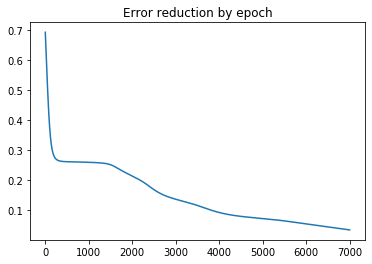

In [50]:
plt.plot(H.history['loss'])
plt.title("Error reduction by epoch")

In [160]:
#Save the trained model and learned weights:
rumnet.save('rumnet_trained_2500eps.h5')

### Create array containing item representations for each input

Often we want to record the internal representations and outputs generated by various inputs as the model trains, or when it is trained. One way to do this is to build sub-models from the components of the main model, using the same input layer but specifying the layer one wishes to record as the output layer. (Maybe there is a more convenient way to do this). This block will create sub-models to record activation patterns from the _Representation_ and _Hidden_ layers:

In [51]:
#Sub-model used for recording item representations
itemrep = Model(inputs = rumnet.input, outputs = rumnet.layers[1].output)

#Sub-model used for recording item-in-context representations
hidrep = Model(rumnet.input, outputs=rumnet.layers[4].output)

Then we can use it to record hidden representations at different layers, as well as using the whole model to generate output patterns.

In [52]:
#Create a numpy array containing the item representations generated by each input item
irep = itemrep.predict([item_input_pats, query_input_pats])

#Create a numpy array containing item-in-context representations for all 32 inputs
iicrep = hidrep.predict([item_input_pats, query_input_pats])

#Create numpy array containing output activations generated by all 32 inputs
outacts = rumnet.predict([item_input_pats, query_input_pats])

To look at hidden representation structure, can build a new sub-model model from pieces of existing, trained model, using the hidden representation layer as the output layer. This model can then be used to generate hidden rep output activations using its predict method, applied to the patterns in the training corpus.

Using the clustering functions fromthe scipy library, we can generate a cluster plot to visualize these representations.

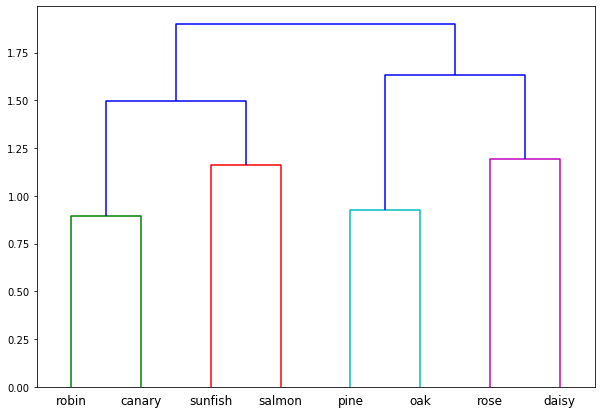

In [9]:
plt.figure(figsize=(10,7))
dend = shc.dendrogram(shc.linkage(out[800:808,], method='average'), labels=inames)

In [10]:
np.savetxt('rumnet_ireps_dev_10k_init_point_1.csv', out, delimiter=',')

## Some results

I still find Python v clunky for doing data analyses, so I save the data to csv files and analyze them in R. But, I will copy-and-paste some results here.

First, do we see progressive differentiation of concepts, with superordinate structure arising first, then basic, then specific, using the current Adam optimizer? The answer is yes, but the initial weights must be set to be fairly small (uniformat distribution sampled from -.1 to .1). Here is a classical MDS of the internal representations over the course of learning:

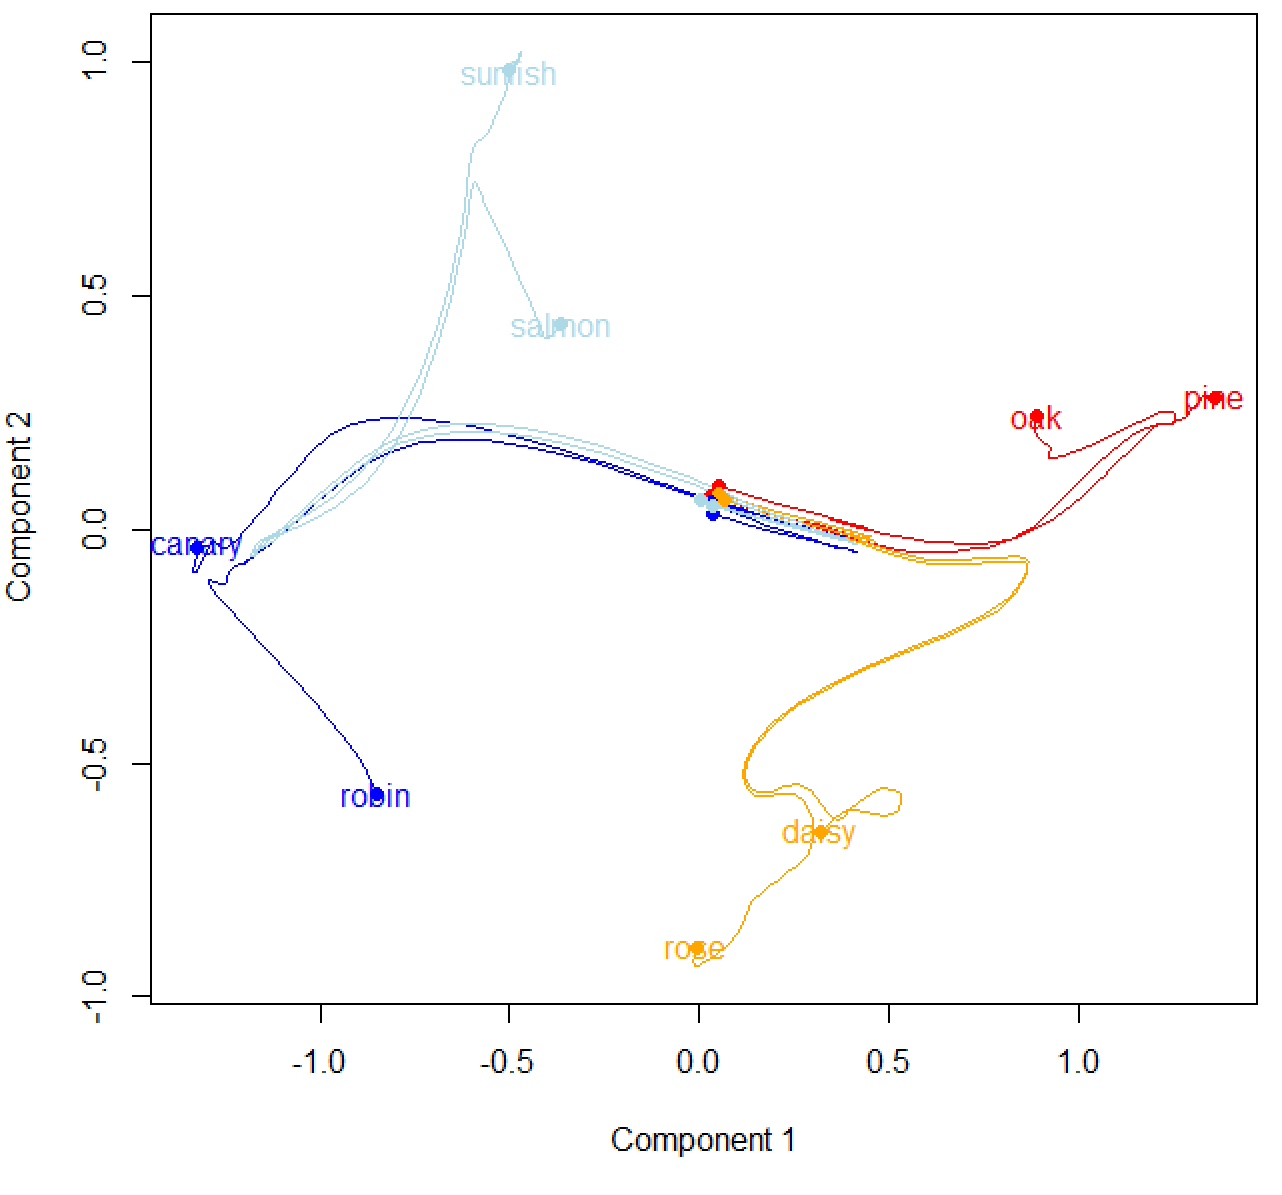

With larger initial weights (e.g. the -.9 to .9 noted in the book), trajectories from initial to final state look more linear; with smaller weights (e.g. -.01 to .01), they are much more nonlinear, with very abrupt changes in trajectory.

Here are the same data as hierarchical cluster plots:

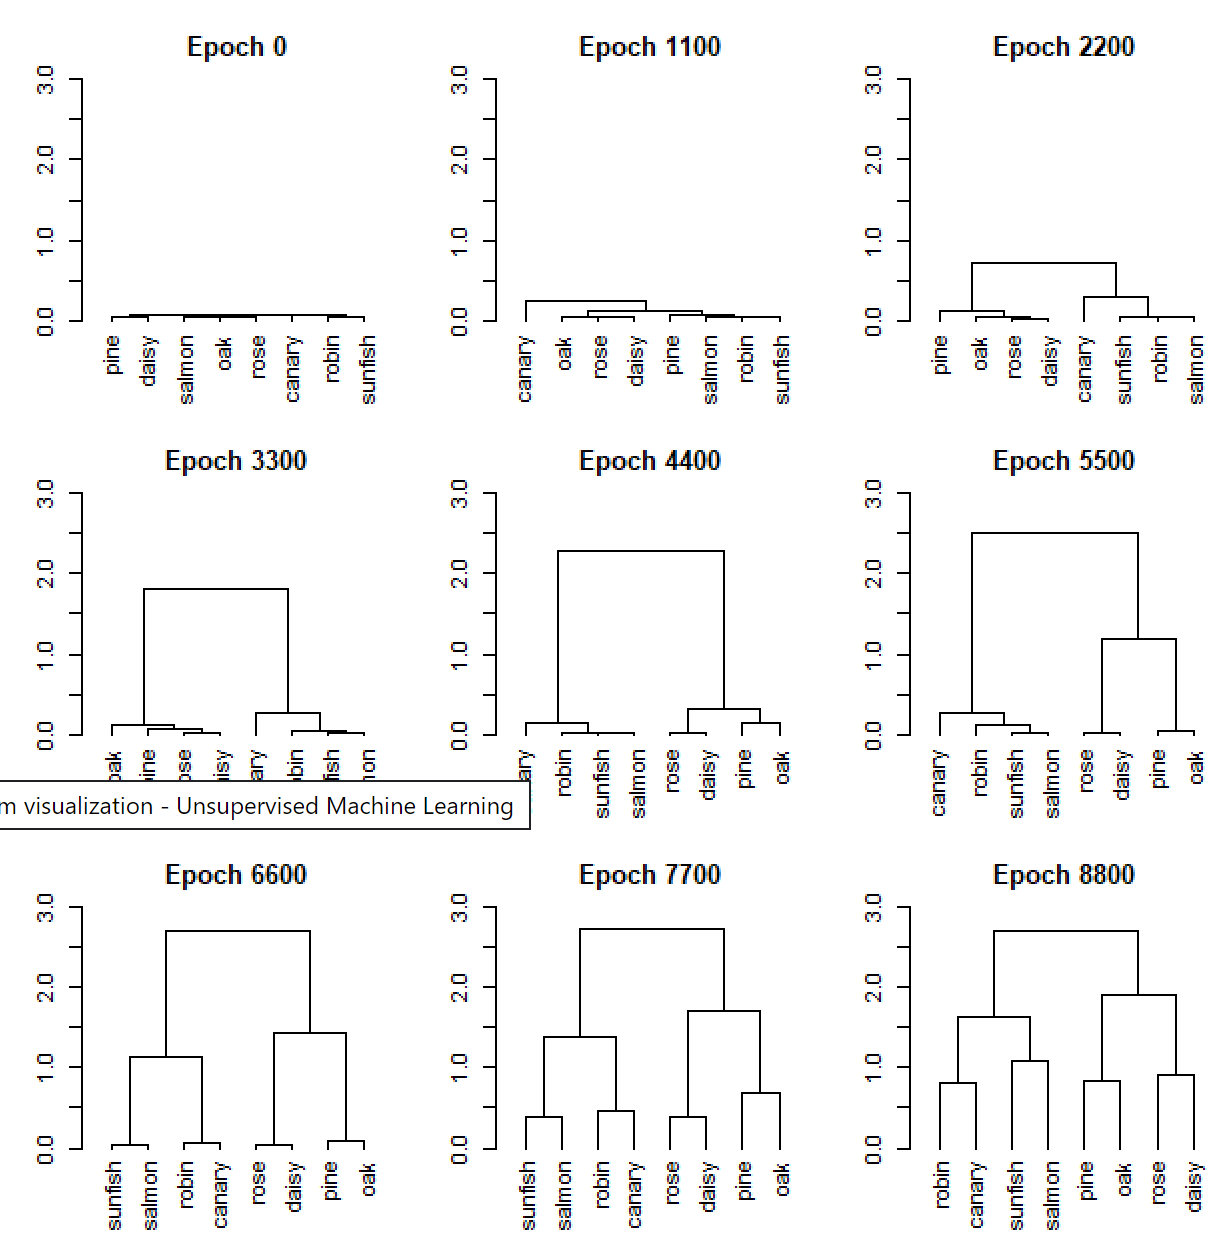